In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    sub_y_te = y[k_indices[k]]
    sub_x_te = x[k_indices[k]]
    sub_y_tr = np.delete(y, k_indices[k], axis=0)
    sub_x_tr = np.delete(x, k_indices[k], axis=0)
    # form data with polynomial degree
    sub_x_te = build_poly(sub_x_te, degree)
    sub_x_tr = build_poly(sub_x_tr, degree)
    # ridge regression
    weights = ridge_regression(sub_y_tr, sub_x_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = compute_mse(sub_y_tr, sub_x_tr, weights)
    loss_te = compute_mse(sub_y_te, sub_x_te, weights)
    return loss_tr, loss_te, weights

Find out the best lambda:

The lowest rmse I got is when setting lambda = 0.004520353656360241


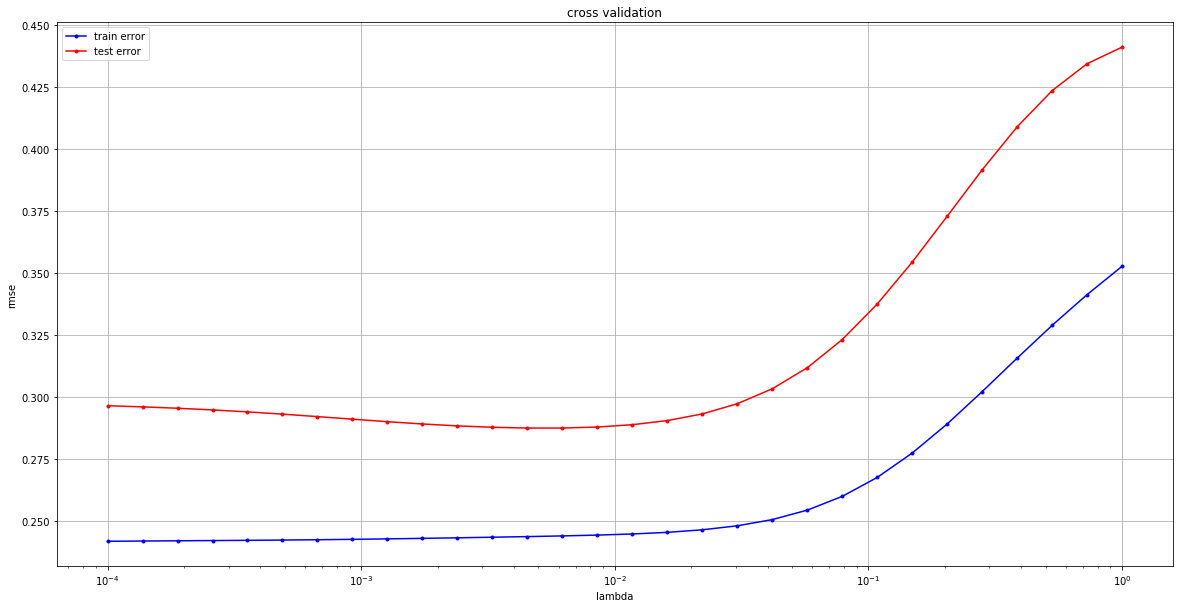

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for lambda_ in lambdas:
        k_rmse_tr = []
        k_rmse_te = []
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr.append(np.sqrt(2 * loss_tr))
            k_rmse_te.append(np.sqrt(2 * loss_te))
        rmse_tr.append(np.mean(k_rmse_tr))
        rmse_te.append(np.mean(k_rmse_te))
    
    print('The lowest rmse I got is when setting lambda =', lambdas[np.argmin(rmse_te)])
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

Find out the best degree:

The lowest rmse I got is when setting degree = 7


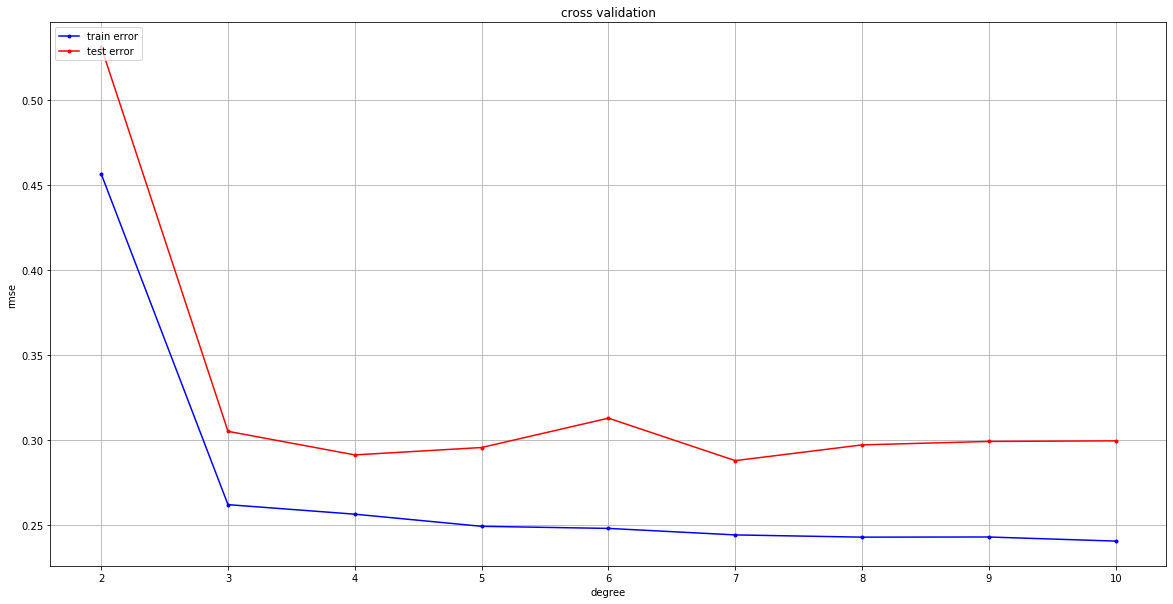

In [6]:
def cross_validation_degree_demo():
    seed = 1
    degrees = np.arange(2, 11)
    k_fold = 4
    lambda_ = 0.004520353656360241
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for degree in degrees:
        k_rmse_tr = []
        k_rmse_te = []
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr.append(np.sqrt(2 * loss_tr))
            k_rmse_te.append(np.sqrt(2 * loss_te))
        rmse_tr.append(sum(k_rmse_tr) / k_fold)
        rmse_te.append(sum(k_rmse_te) / k_fold)
  
    plt.figure(figsize=(20, 10))
    plt.plot(degrees, rmse_tr, marker=".", color='b', label='train error')
    plt.plot(degrees, rmse_te, marker=".", color='r', label='test error')
    plt.xlabel("degree")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")
    print('The lowest rmse I got is when setting degree =', degrees[np.argmin(rmse_te)])

cross_validation_degree_demo()

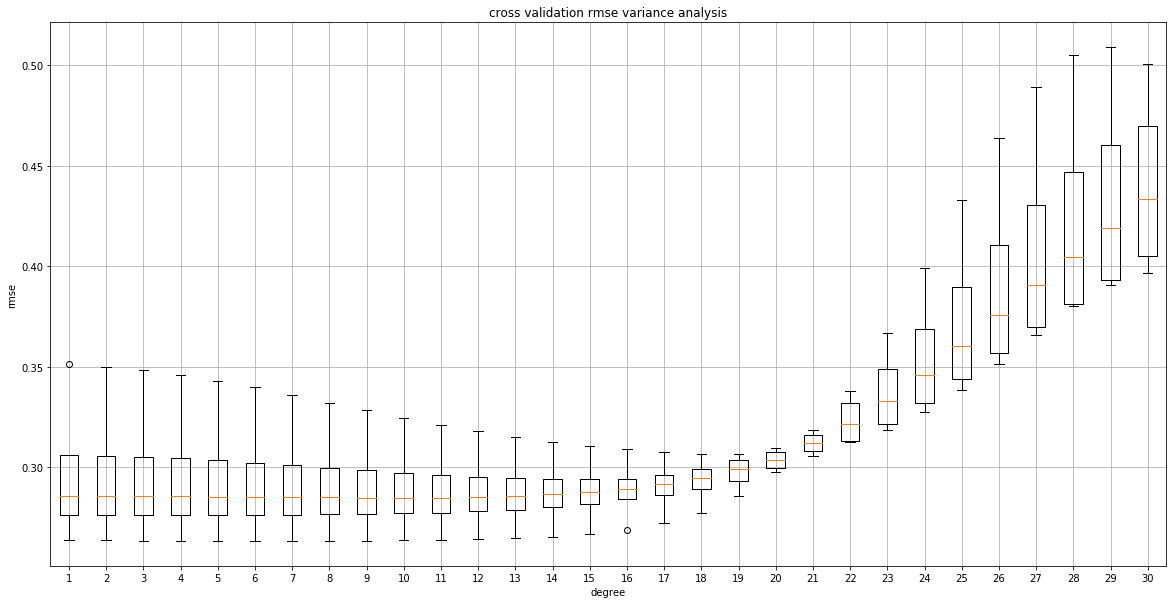

In [7]:
def cross_validation_rmse_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for lambda_ in lambdas:
        k_rmse_tr = []
        k_rmse_te = []
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr.append(np.sqrt(2 * loss_tr))
            k_rmse_te.append(np.sqrt(2 * loss_te))
        rmse_tr.append(k_rmse_tr)
        rmse_te.append(k_rmse_te)
  
    plt.figure(figsize=(20, 10))
    plt.boxplot(rmse_te)
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation rmse variance analysis")
    plt.grid(True)

cross_validation_rmse_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

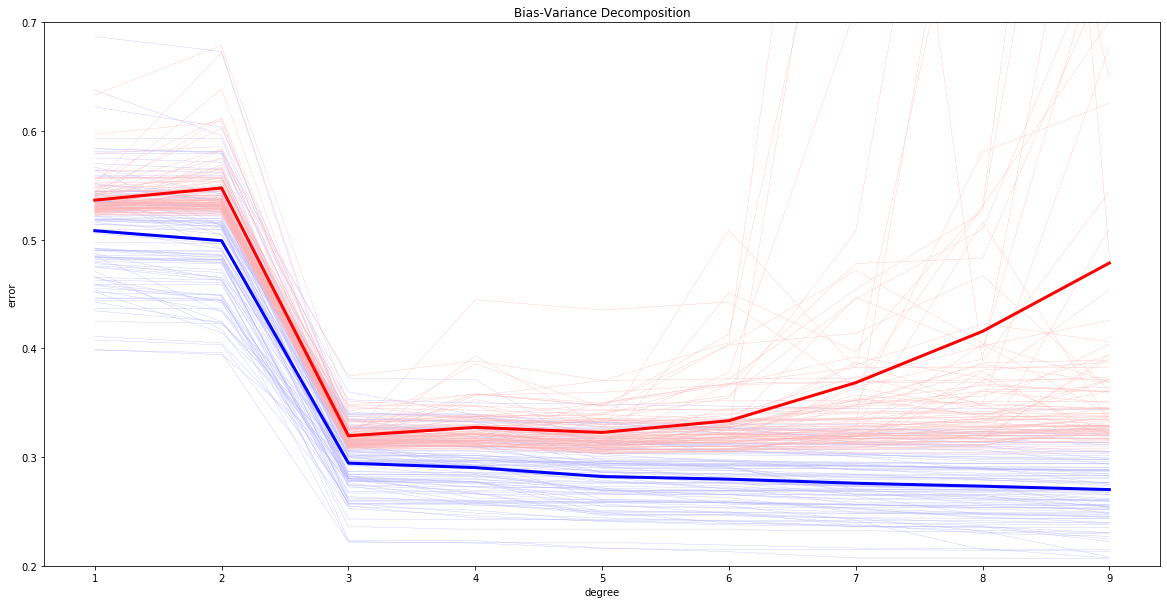

In [8]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        # bias_variance_decomposition
        for index_degree, degree in enumerate(degrees):
            # form train and test data with polynomial basis function
            dx_tr = build_poly(x_tr, degree)
            dx_te = build_poly(x_te, degree)
            # calcualte weight through least square
            weights = least_squares(y_tr, dx_tr)
            # calculate RMSE for train and test data
            mse_tr = compute_mse(y_tr, dx_tr, weights)
            mse_te = compute_mse(y_te, dx_te, weights)
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * mse_tr)
            rmse_te[index_seed, index_degree] = np.sqrt(2 * mse_te)

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()

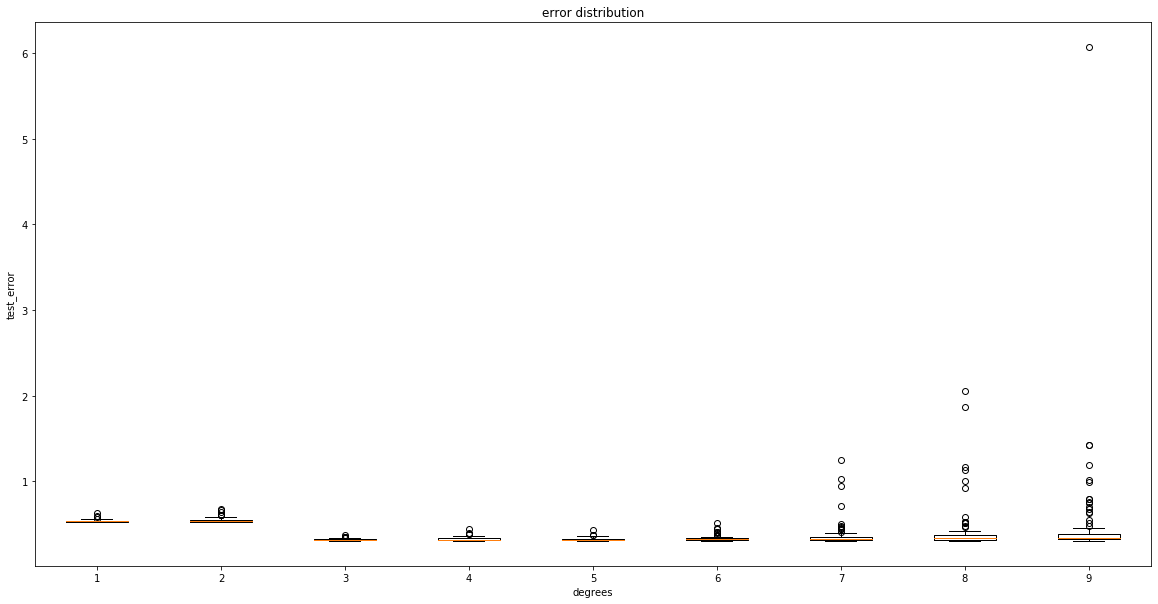

In [9]:
def test_errors_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        # bias_variance_decomposition
        for index_degree, degree in enumerate(degrees):
            # form train and test data with polynomial basis function
            dx_tr = build_poly(x_tr, degree)
            dx_te = build_poly(x_te, degree)
            # calcualte weight through least square
            weights = least_squares(y_tr, dx_tr)
            # calculate RMSE for train and test data
            mse_te = compute_mse(y_te, dx_te, weights)
            rmse_te[index_seed, index_degree] = np.sqrt(2 * mse_te)

    plt.figure(figsize=(20, 10))
    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")

test_errors_variance_demo()

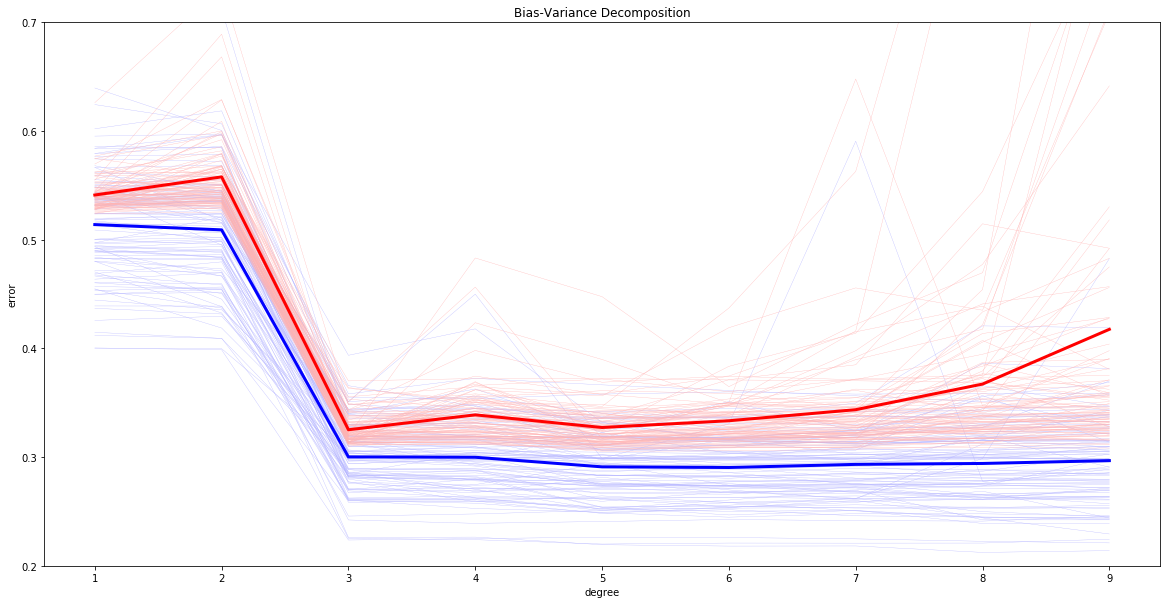

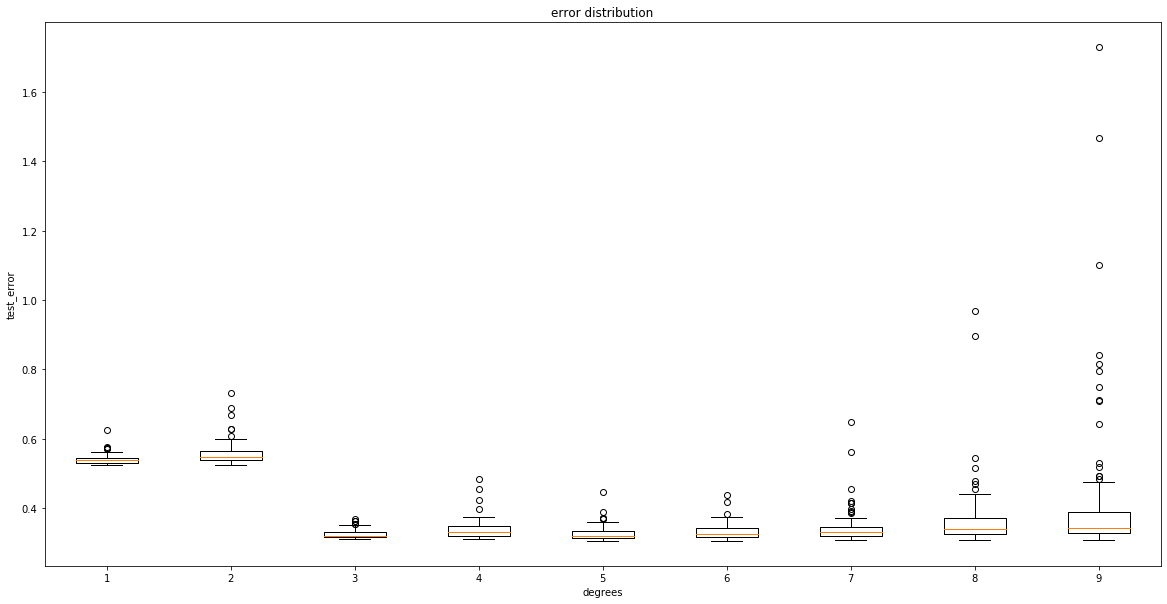

In [10]:
def ridge_bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    lambdas = np.logspace(-4, 0, 30)
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        k_fold = 4
        k_indices = build_k_indices(y_tr, k_fold, seed)
        
        # bias_variance_decomposition
        for index_degree, degree in enumerate(degrees):
            dx_tr = build_poly(x_tr, degree)
            dx_te = build_poly(x_te, degree)
            d_rmse_tr = []
            d_rmse_te = []
            d_weights = []
            # find the best lambda in ridge regression using cross validation
            for lambda_ in lambdas:
                k_rmse_te = []
                k_weights = []
                for k in range(k_fold):
                    _, loss_te, weights = cross_validation(y_tr, x_tr, k_indices, k, lambda_, degree)
                    k_rmse_te.append(np.sqrt(2 * loss_te))
                    k_weights.append(weights)
                d_rmse_te.append(np.mean(k_rmse_te))
                d_weights.append(k_weights)
                
            best_lambda_index = np.argmin(d_rmse_te)
            best_weights = d_weights[best_lambda_index]
            
            # calculate RMSE for train and test data using the best weights (lowest k test rmse)
            mse_tr = np.mean([compute_mse(y_tr, dx_tr, weights) for weights in best_weights])
            mse_te = np.mean([compute_mse(y_te, dx_te, weights) for weights in best_weights])
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * mse_tr)
            rmse_te[index_seed, index_degree] = np.sqrt(2 * mse_te)

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    plt.figure(figsize=(20, 10))
    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")

ridge_bias_variance_demo()